In [1]:
import torch
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random
from torchvision import transforms
import os
from torch import nn, optim
from torch.nn import functional as F
from tqdm import tqdm
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


dataset_dir = "asl_dataset"
len_img = 128

In [2]:
transform = transforms.Compose([
    transforms.Resize((len_img, len_img)), 
    transforms.ToTensor(),  
])

In [3]:
dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)
dataset

Dataset ImageFolder
    Number of datapoints: 2515
    Root location: asl_dataset
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [4]:
len(dataset.classes)

36

In [6]:
label_to_num = dataset.class_to_idx
num_to_label = {}
for key, value in label_to_num.items():
    num_to_label[value] = key

label_to_num

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'a': 10,
 'b': 11,
 'c': 12,
 'd': 13,
 'e': 14,
 'f': 15,
 'g': 16,
 'h': 17,
 'i': 18,
 'j': 19,
 'k': 20,
 'l': 21,
 'm': 22,
 'n': 23,
 'o': 24,
 'p': 25,
 'q': 26,
 'r': 27,
 's': 28,
 't': 29,
 'u': 30,
 'v': 31,
 'w': 32,
 'x': 33,
 'y': 34,
 'z': 35}

In [8]:
img, label = dataset[200]
img.permute(1, 2, 0), label, img.shape

(tensor([[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]]),
 2,
 torch.S

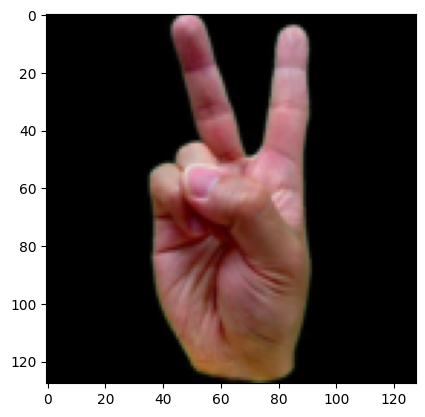

In [31]:
plt.imshow(img.permute(1, 2, 0))

In [32]:
type(dataset)

torchvision.datasets.folder.ImageFolder

In [33]:
train_size = int(0.8 * (len(dataset)))
test_size = int(len(dataset) - train_size)
train_size, test_size

(2012, 503)

In [34]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
len(train_dataset), len(test_dataset)

(2012, 503)

In [35]:
train_dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 8)

In [36]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
len(train_dataloader), len(test_dataloader)

(126, 32)

In [37]:
dataloader_1 = next(iter(train_dataloader))

torch.Size([3, 128, 128])


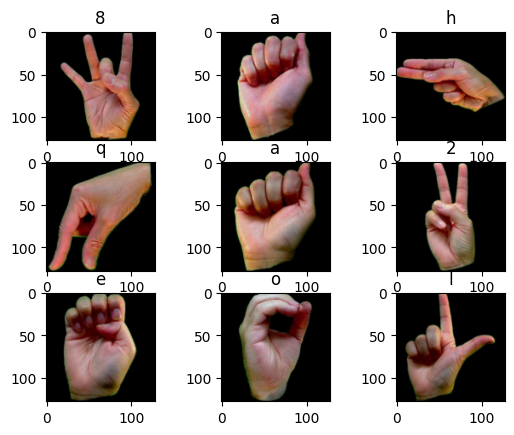

In [38]:
images, labels = dataloader_1[0], dataloader_1[1]
print(images[0].shape)
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(num_to_label[labels[i].item()])

In [39]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_units):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 29 * 29,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [40]:
model = TinyVGG(input_shape=3, output_shape=len(dataset.classes), hidden_units=16)
model

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=13456, out_features=36, bias=True)
  )
)

In [41]:
model(img.unsqueeze(0))

tensor([[-0.0073,  0.0078, -0.0090,  0.0038,  0.0128,  0.0009, -0.0158,  0.0139,
          0.0079, -0.0043,  0.0118, -0.0185,  0.0041, -0.0049, -0.0098,  0.0010,
          0.0068,  0.0016, -0.0260,  0.0164, -0.0197,  0.0021, -0.0055,  0.0010,
         -0.0012,  0.0184,  0.0111,  0.0070, -0.0075,  0.0218, -0.0021,  0.0039,
         -0.0099,  0.0043,  0.0172, -0.0051]], grad_fn=<AddmmBackward0>)

In [42]:
def accuracy(y_labels, y):
    return (y_labels==y).sum().item()/len(y_labels)

In [43]:
def train_step(model, dataloader, loss_fn, optimizer):
    model.train()

    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        y_prob = torch.softmax(y_pred, dim=1)
        y_labels = torch.argmax(y_prob, dim=1)
        acc = accuracy(y_labels, y)
        train_acc += acc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc
        
        
        

In [44]:
def test_step(model, dataloader, loss_fn):
    model.eval()
    with torch.inference_mode():
        test_loss, test_acc = 0, 0
        for batch, (X, y) in enumerate(dataloader):
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss
            y_prob = torch.softmax(y_pred, dim=1)
            y_labels = torch.argmax(y_prob, dim=1)
            acc = accuracy(y_labels, y)
            test_acc += acc

        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [45]:
def train(num_epochs, model, train_dataloader, test_dataloader, loss_fn, optimizer):
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
              }
    for i in tqdm(range(num_epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn)
        print(f"Epoch: {i} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.3f} | Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.3f}")
        results["train_loss"].append(train_loss.item())
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss.item())
        results["test_acc"].append(test_acc)

    return results

In [46]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [47]:
results = train(10, model, train_dataloader, test_dataloader, loss_fn, optimizer)

 10%|██████████▌                                                                                              | 1/10 [00:29<04:24, 29.44s/it]

Epoch: 0 | Train Loss: 1.548 | Train Acc: 0.577 | Test Loss: 0.485 | Test Acc: 0.863


 20%|█████████████████████                                                                                    | 2/10 [00:57<03:50, 28.84s/it]

Epoch: 1 | Train Loss: 0.299 | Train Acc: 0.900 | Test Loss: 0.179 | Test Acc: 0.926


 30%|███████████████████████████████▌                                                                         | 3/10 [01:26<03:22, 28.95s/it]

Epoch: 2 | Train Loss: 0.125 | Train Acc: 0.956 | Test Loss: 0.210 | Test Acc: 0.943


 40%|██████████████████████████████████████████                                                               | 4/10 [01:55<02:52, 28.67s/it]

Epoch: 3 | Train Loss: 0.062 | Train Acc: 0.982 | Test Loss: 0.057 | Test Acc: 0.980


 50%|████████████████████████████████████████████████████▌                                                    | 5/10 [02:23<02:23, 28.62s/it]

Epoch: 4 | Train Loss: 0.030 | Train Acc: 0.991 | Test Loss: 0.078 | Test Acc: 0.982


 60%|███████████████████████████████████████████████████████████████                                          | 6/10 [02:51<01:53, 28.40s/it]

Epoch: 5 | Train Loss: 0.011 | Train Acc: 0.997 | Test Loss: 0.047 | Test Acc: 0.990


 70%|█████████████████████████████████████████████████████████████████████████▌                               | 7/10 [03:20<01:25, 28.58s/it]

Epoch: 6 | Train Loss: 0.002 | Train Acc: 1.000 | Test Loss: 0.050 | Test Acc: 0.984


 80%|████████████████████████████████████████████████████████████████████████████████████                     | 8/10 [03:48<00:56, 28.19s/it]

Epoch: 7 | Train Loss: 0.001 | Train Acc: 1.000 | Test Loss: 0.057 | Test Acc: 0.984


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▌          | 9/10 [04:15<00:27, 27.97s/it]

Epoch: 8 | Train Loss: 0.001 | Train Acc: 1.000 | Test Loss: 0.056 | Test Acc: 0.984


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:44<00:00, 28.41s/it]

Epoch: 9 | Train Loss: 0.000 | Train Acc: 1.000 | Test Loss: 0.057 | Test Acc: 0.984


In [48]:
results

{'train_loss': [1.547780156135559,
  0.29874634742736816,
  0.12512052059173584,
  0.061637476086616516,
  0.029941361397504807,
  0.011105742305517197,
  0.001566808088682592,
  0.0005706329829990864,
  0.0005115217645652592,
  0.0002622686151880771],
 'train_acc': [0.5772156084656085,
  0.9002976190476191,
  0.9558531746031746,
  0.9821428571428571,
  0.9905753968253969,
  0.9965277777777778,
  0.9995039682539683,
  1.0,
  1.0,
  1.0],
 'test_loss': [0.4850970208644867,
  0.17903873324394226,
  0.20950764417648315,
  0.05706234276294708,
  0.07797911763191223,
  0.04650505632162094,
  0.050232358276844025,
  0.05714579299092293,
  0.05614767596125603,
  0.0570211224257946],
 'test_acc': [0.86328125,
  0.92578125,
  0.9428013392857143,
  0.98046875,
  0.9818638392857143,
  0.990234375,
  0.9838169642857143,
  0.9838169642857143,
  0.9838169642857143,
  0.9838169642857143]}

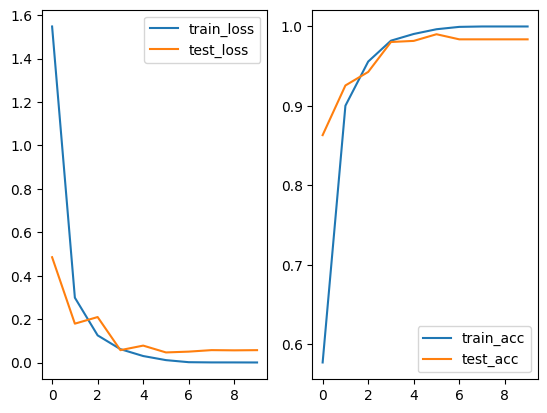

In [53]:
plt.subplot(1, 2, 1)
plt.plot(results["train_loss"], label="train_loss")
plt.plot(results["test_loss"], label="test_loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(results["train_acc"], label="train_acc")
plt.plot(results["test_acc"], label="test_acc")
plt.legend()

In [55]:
y_preds = []
y_og = []
model.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        y_pred = model(X)
        y_prob = torch.softmax(y_pred, dim=1)
        y_labels = torch.argmax(y_prob, dim=1)
        y_preds.append(y_labels)
        y_og.append(y)

y_pred_tensor = torch.cat(y_preds)
y_og_tensor = torch.cat(y_og)    

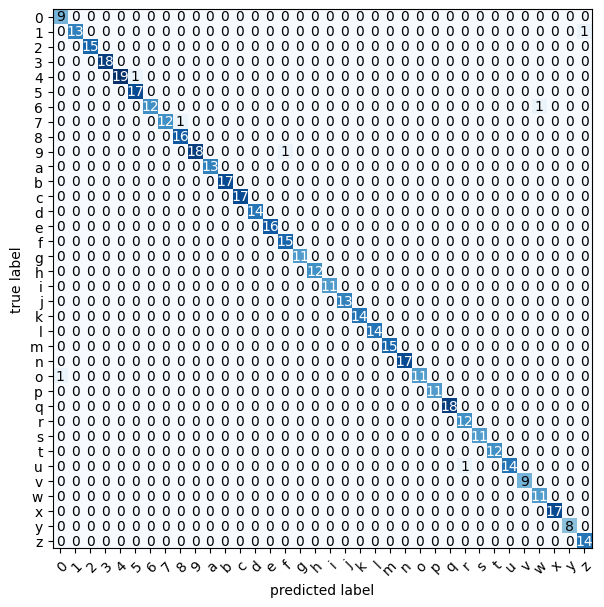

In [56]:
confmat = ConfusionMatrix(num_classes = len(dataset.classes), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor, target=y_og_tensor)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with numpy
    class_names=dataset.classes,
    figsize=(10, 7)
)

In [58]:
torch.save(model.state_dict(), "model.pth")